In [495]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Preparation

In [496]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
sns.set(style='white', context='notebook', palette='deep')

In [497]:
# Load Data
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test_pid = test["PassengerId"]

In [498]:
# Find Outliers based on IQR (Inter Quantile Range)

def find_outlier(df, n, features):
    outlier_index = []
    
    for feat in features:
        Q1 = np.percentile(df[feat], 25)
        Q3 = np.percentile(df[feat], 75)
        IQR = Q3 - Q1
        
        step = 1.5 * IQR
        outlier_col = df[(df[feat] < Q1 - step) | (df[feat] > Q3 + step )].index
        outlier_index.extend(outlier_col)
        
    outlier_index = Counter(outlier_index)
    multi_outliers = list(k for k, v in outlier_index.items() if v > n)
    
    return multi_outliers

outliers = find_outlier(train, 2, ["Age", "SibSp", "Parch", "Fare"])
len(outliers)

10

In [499]:
train.loc[outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [500]:
train = train.drop(outliers, axis=0).reset_index(drop=True)

In [501]:
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
len(dataset)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


1299

In [502]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [503]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [504]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [505]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

## Numerical Values

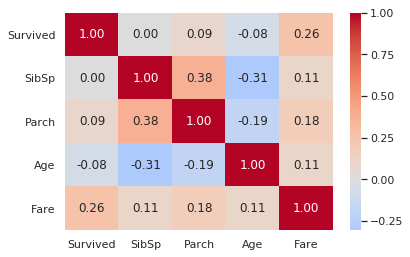

In [506]:
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0.0)

### SibSp

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


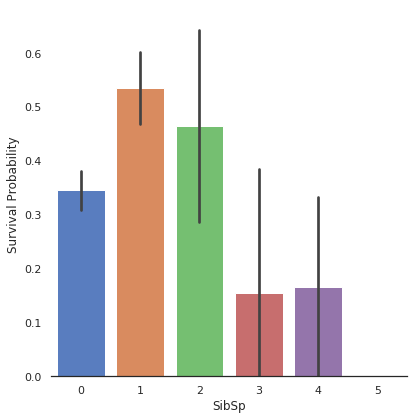

In [507]:
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

*Observation:*

Single passenger or those who has one or two other persons have more chance to survive

### Parch

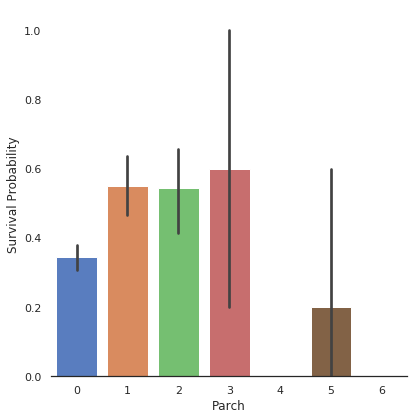

In [508]:
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

*Observation:*

* Small families have more chance to survive than Single or large families
* Parch = 3 has significant deviation

### Age

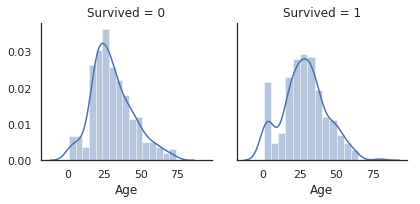

In [509]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

*Observations:*

* Age was not correlated with Survived but certain range seems to have correlation
* Very young passengers survived well
* Very old passengers did not survive much
* Young adult passengers did not survive much
* There are a lot of missing records, which need to be fillen later

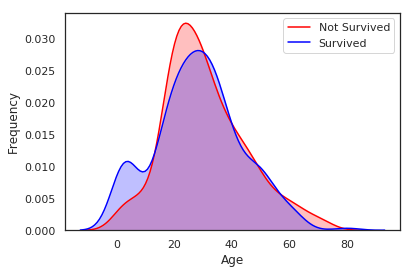

In [510]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

### Fare

In [511]:
# Fill the median value to the missing one record
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

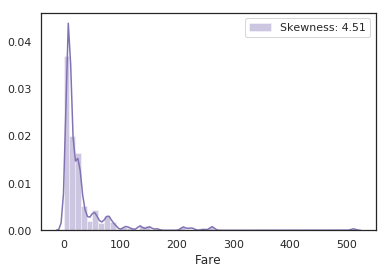

In [512]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness: %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

*Observation:*

* Fare is very skewed. Better to take log in this case.

In [513]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

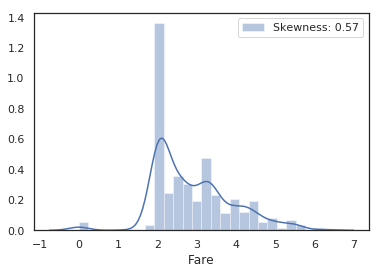

In [514]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness: %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

## Categorical Values

### Sex

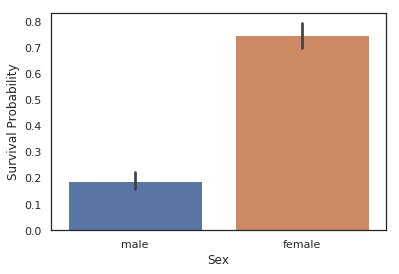

In [515]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [516]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


*Observation:*

* Clearly, female has much more chance to survive than male

### Pclass

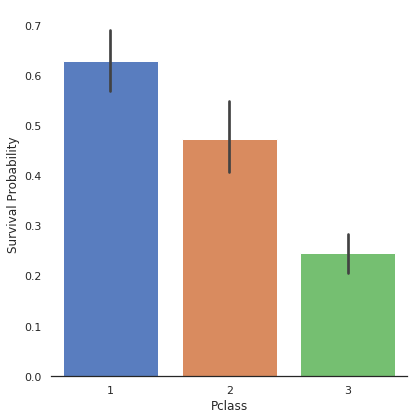

In [517]:
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

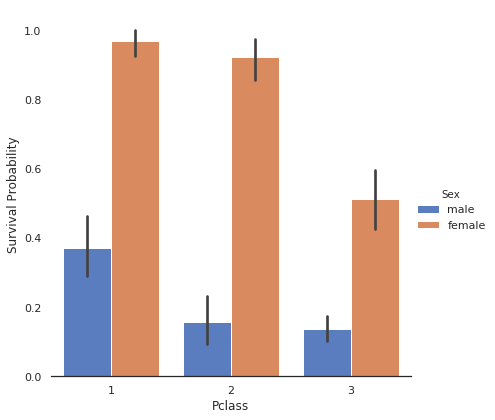

In [518]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

*Observations:*

* Higher class passenger has more chance of survival
* This is consistent for both female and male

### Embarked

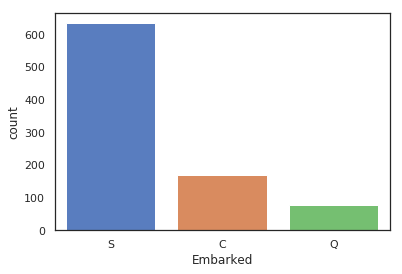

In [519]:
g = sns.countplot(x="Embarked", data=train, palette="muted")

In [520]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")
dataset["Embarked"].isnull().sum()

0

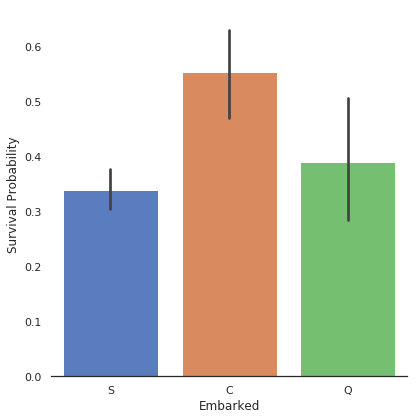

In [521]:
g = sns.factorplot(x="Embarked", y="Survived", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

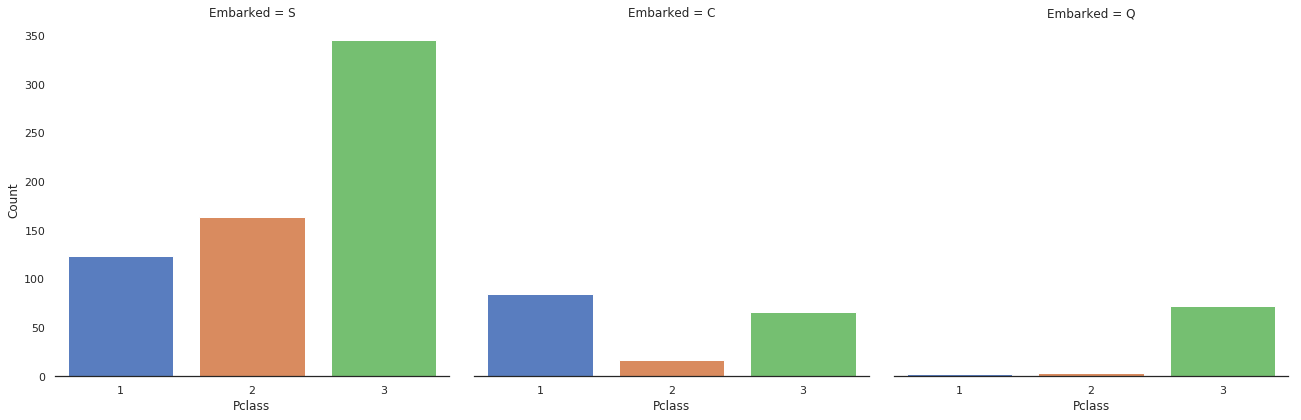

In [522]:
# Check if high survival rate for "C" is due to Passanger Class
g = sns.factorplot("Pclass", col="Embarked", data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

*Observation:*

* Passengers embarked from "C" has higher survival rate but it seems to attribute to the fact that they are mostly 1st class passengers

# Fill Missing Values

## Age

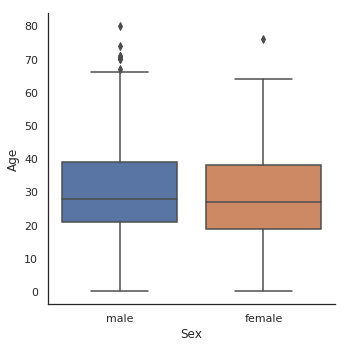

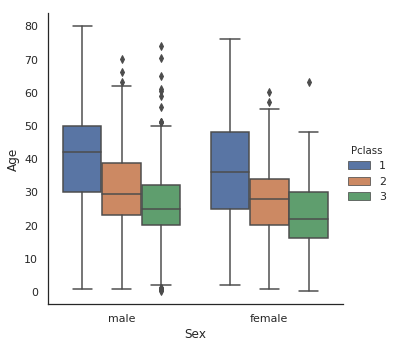

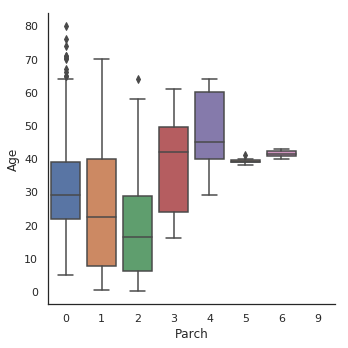

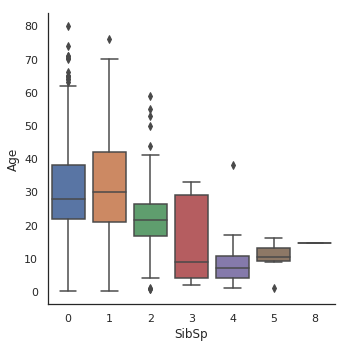

In [523]:
# To impute missing values, check correlation with Age
g = sns.factorplot(y="Age", x="Sex", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Parch", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="SibSp", data=dataset, kind="box")

*Observations:*

* Sex is not correlated
* The more parent/children, the older
* The more siglings/spouses, the younger

In [524]:
# Categorical Encoding
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

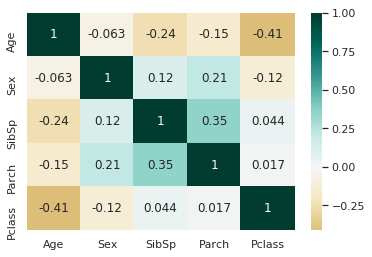

In [525]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap="BrBG", annot=True, center=0.0)

*Observations:*

* Age is not correlated with Sex
* Age is negatively correlated with SibSp, Parch and Pclass
* This observation of Parch is different from the one from factorplot probably because of the trend in smaller Parch, but anyway worth using it as it correlates

In [526]:
nan_age_index = list(dataset[dataset["Age"].isnull()].index)
for i in nan_age_index:
    age_all_med = dataset["Age"].median()
    age_group_med = dataset["Age"][(dataset["SibSp"]==dataset["SibSp"].iloc[i]) & (dataset["Parch"]==dataset["Parch"].iloc[i]) & (dataset["Pclass"]==dataset["Pclass"].iloc[i])].median()
    if not np.isnan(age_group_med):
        dataset["Age"].iloc[i] = age_group_med
    else:
        dataset["Age"].iloc[i] = age_all_med


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [527]:
dataset.isnull().sum()

Age               0
Cabin          1007
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

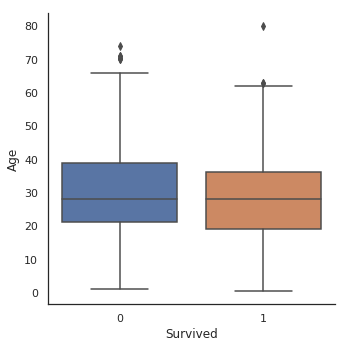

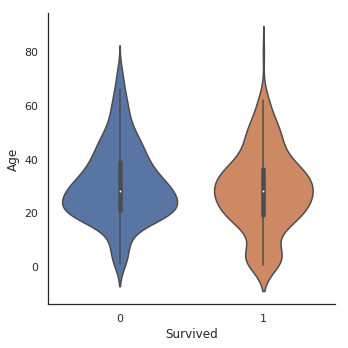

In [528]:
g = sns.factorplot(x="Survived", y="Age", data=train, kind="box")
g = sns.factorplot(x="Survived", y="Age", data=train, kind="violin")

# Feature Engineering

## Name

In [529]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [530]:
dataset_title = [name.split(",")[1].split(".")[0].strip() for name in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

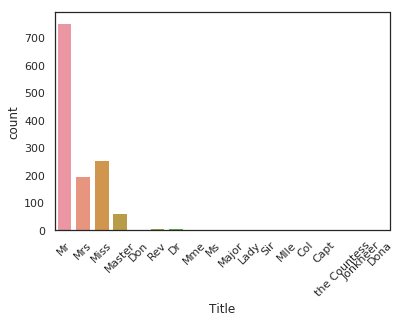

In [531]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [532]:
# Group rare titles, conbine ones having the same meaning and conver to integer
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

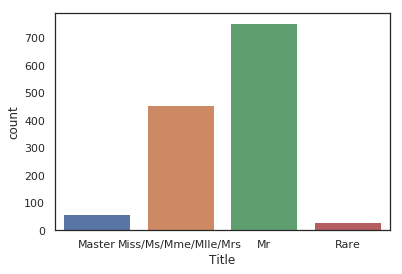

In [533]:
g = sns.countplot(x="Title", data=dataset)
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

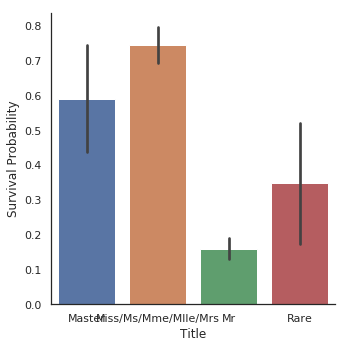

In [534]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])
g = g.set_ylabels("Survival Probability")

In [535]:
dataset.drop(labels=["Name"], axis=1, inplace=True)

## Family Size

In [536]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

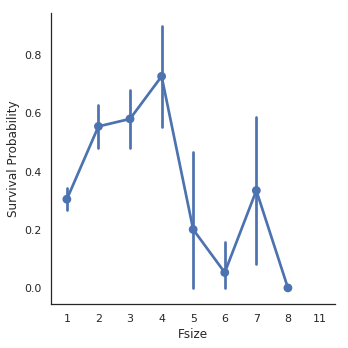

In [537]:
g = sns.factorplot(x="Fsize", y="Survived", data=dataset)
g = g.set_ylabels("Survival Probability")

In [538]:
# Create categorical features based on the family size
dataset["Single"] = dataset["Fsize"].map(lambda x: 1 if x == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda x: 1 if x == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda x: 1 if 3 <= x <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda x: 1 if x >= 5 else 0)

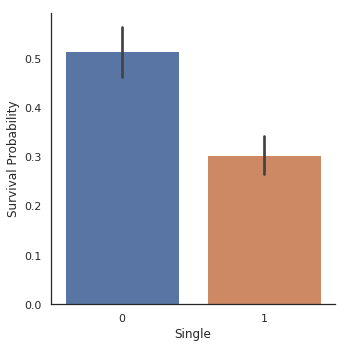

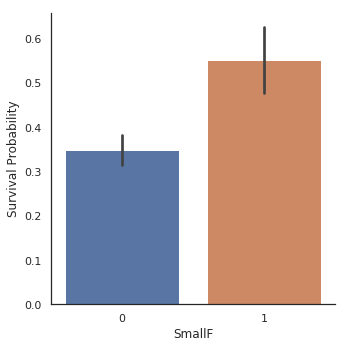

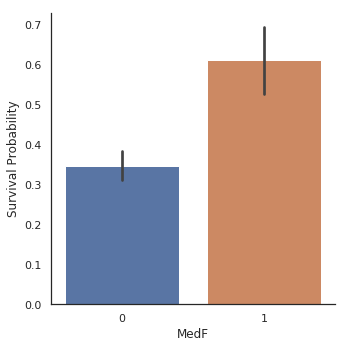

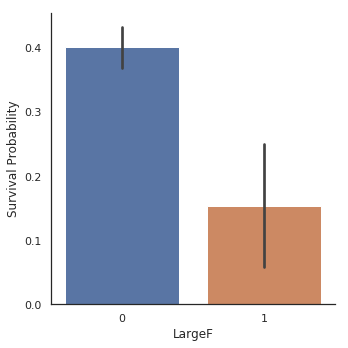

In [539]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

## One-hot encoding of Title and Embarked

In [540]:
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [541]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


## Cabin

In [542]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [543]:
dataset["Cabin"].isnull().sum()

1007

In [544]:
# Assuming missing value means the passenger does not have a cabin, assign "X". Also keep the first letter only.
dataset["Cabin"] = pd.Series(cabin[0] if pd.notnull(cabin) else 'X' for cabin in dataset["Cabin"])

In [545]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

0    X
1    C
2    X
3    C
4    X
Name: Cabin, dtype: object

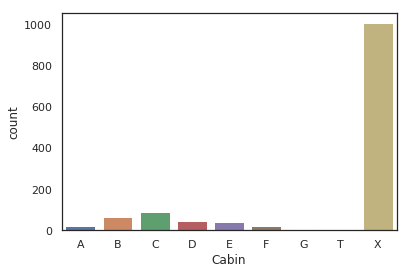

In [546]:
g = sns.countplot(dataset["Cabin"], order=['A','B','C','D','E','F','G','T','X'])

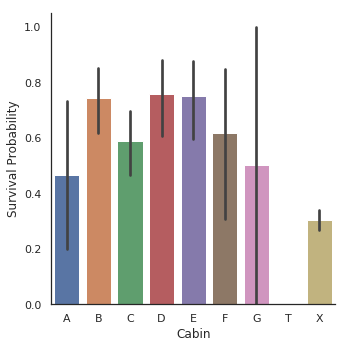

In [547]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

*Observations:*

* Cabin A, G, T has too small numbers of samples and thus the standard deviation is too large
* Cabin B, C, D, E and F  has higher survival rate than X, so anyway keep this feature

In [548]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin")

In [549]:
# Drop G and T
dataset.drop(labels = ["Cabin_G", "Cabin_T"], axis=1, inplace=True)

## Ticket

In [550]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [551]:
# Extract prefix, with "X" for those without prefix

ticket_list = []

for ticket in dataset["Ticket"]:
    if not ticket.isdigit():
        ticket_prefix = ticket.replace(".", "").replace("/", "").strip().split(' ')[0]
        print(ticket_prefix)
        ticket_list.append(ticket_prefix)
    else:
        ticket_list.append("X")

dataset["Ticket"] = ticket_list
dataset["Ticket"].head()

A5
PC
STONO2
PP
A5
PC
PC
CA
PC
A5
SCParis
SCA4
A4
PC
CA
CA
CA
PC
CA
SP
CA
CA
SOC
SOC
WC
SOTONOQ
WEP
CA
PC
PC
STONO
PC
SOC
A4
C
SOTONOQ
A5
CA
SCPARIS
PC
STONO2
CA
WC
SOP
A5
A5
Fa
PC
SOTONOQ
CA
PC
STONO
PC
LINE
SCPARIS
PC
PC
A5
SOTONOQ
FCC
A5
STONO2
WC
SOTONOQ
PP
SWPP
A5
CA
WC
CA
SCOW
WC
STONO
A5
PC
PC
CA
PC
PC
LINE
PC
CA
A5
SCParis
PC
PC
LINE
A5
PC
PPP
PC
PC
FCC
A5
PC
PC
PC
CA
SCPARIS
SOTONOQ
C
PC
PC
PC
C
PC
STONO
SOC
CA
SC
PP
STONO
STONO2
STONO
A5
A4
SOTONOQ
SCAH
STONO
WC
CA
FCC
CA
A5
FCC
AS
SOTONOQ
CA
SCAH
CA
A5
A5
CA
SOTONOQ
PC
A4
CA
PC
C
SOTONOQ
PC
PC
CA
WC
PC
FCC
PC
WEP
PC
SCPARIS
CA
PC
SOTONOQ
SOTONOQ
A4
SWPP
PC
A4
STONO
A5
STONO
A5
SCAH
LINE
PC
SCParis
PC
SOTONOQ
A5
STONO
CA
PC
PC
SOPP
CA
SOC
PC
STONO
SOC
A5
FC
CA
CA
PC
PC
CA
SCParis
PC
PC
PC
PC
PC
STONO2
WC
PC
PC
STONO
WEP
CA
SOTONO2
SOPP
WC
SOTONOQ
CA
PC
PC
CA
A4
STONO2
SCPARIS
C
SCPARIS
PC
SOTONO2
SOPP
CA
PC
SCPARIS
PC
PPP
CASOTON
SOTONOQ
WC
A4
WEP
SCPARIS
STONO2
PC
C
PC
PC
PC
A5
SCAH
CA
CA
WC
SOTONOQ
STONO
PC
CA
SCPARIS
SCA3


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]), <a list of 37 Text xticklabel objects>)

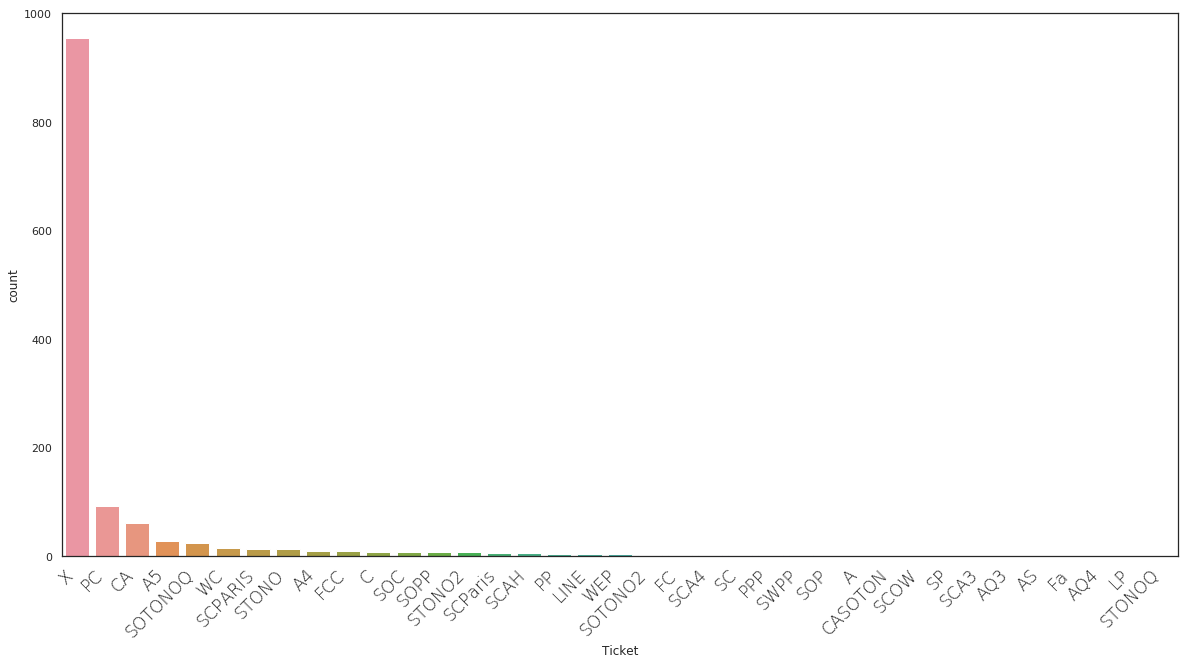

In [552]:
# Check the group by numbers
plt.figure(figsize=(20,10))
g = sns.countplot(dataset["Ticket"], order=dataset['Ticket'].value_counts().index)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

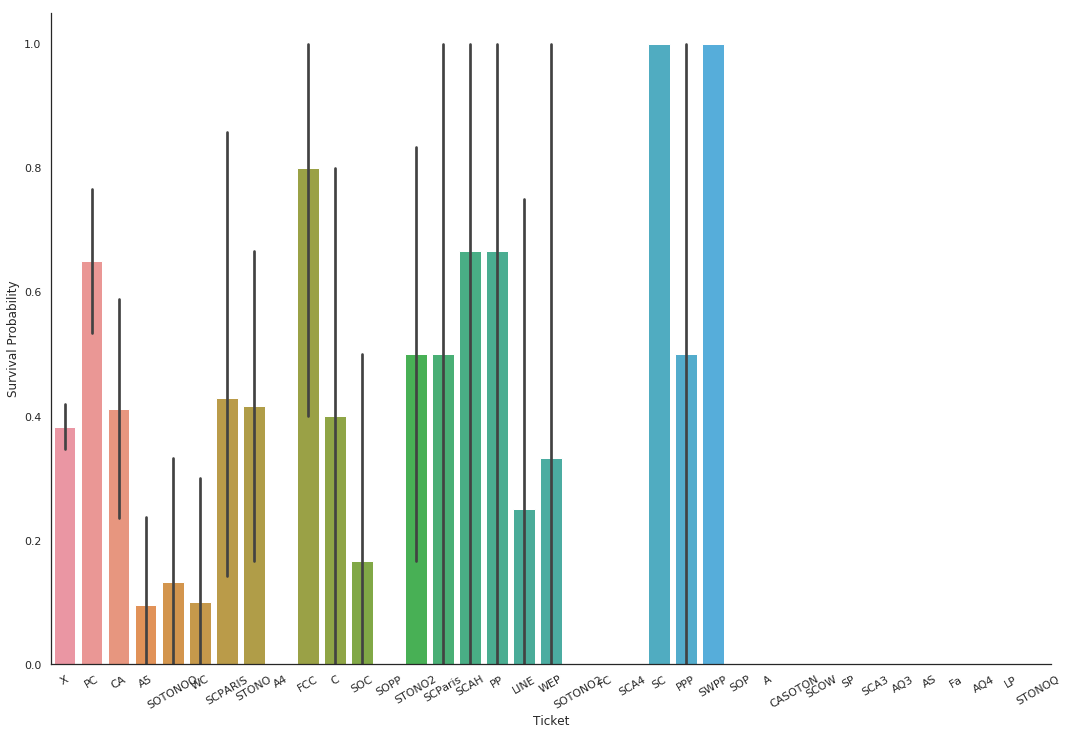

In [553]:
# Check the probability per prefix
g = sns.factorplot(y="Survived", x="Ticket", data=dataset, kind="bar", height=10, aspect=1.5, order=dataset['Ticket'].value_counts().index)
g = g.set_ylabels("Survival Probability")
g.set_xticklabels(rotation=30)

In [554]:
# Use only the first 5
dataset["Ticket_X"] = pd.Series(1 if ticket == 'X' else 0 for ticket in dataset["Ticket"])
dataset["Ticket_PC"] = pd.Series(1 if ticket == 'PC' else 0 for ticket in dataset["Ticket"])
dataset["Ticket_CA"] = pd.Series(1 if ticket == 'CA' else 0 for ticket in dataset["Ticket"])
dataset["Ticket_A5"] = pd.Series(1 if ticket == 'A5' else 0 for ticket in dataset["Ticket"])
dataset["Ticket_SOTONOQ"] = pd.Series(1 if ticket == 'STONOQ' else 0 for ticket in dataset["Ticket"])
dataset.drop(labels=["Ticket"], axis=1, inplace=True)
dataset.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Fsize,Single,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_X,Ticket_X,Ticket_PC,Ticket_CA,Ticket_A5,Ticket_SOTONOQ
0,22.0,1.981001,0,1,3,0,1,0.0,2,0,...,0,0,0,0,1,0,0,0,1,0
1,38.0,4.266662,0,2,1,1,1,1.0,2,0,...,1,0,0,0,0,0,1,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1,1.0,2,0,...,1,0,0,0,0,1,0,0,0,0
4,35.0,2.085672,0,5,3,0,0,0.0,1,1,...,0,0,0,0,1,1,0,0,0,0


## Pclass

In [555]:
# One hot encoding as the values are 1, 2, 3
# dataset["Pclass"].astype("category").head()
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

## Drop Passanger Id

In [556]:
dataset.drop(labels = ["PassengerId"], axis=1, inplace=True)

In [557]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,Cabin_F,Cabin_X,Ticket_X,Ticket_PC,Ticket_CA,Ticket_A5,Ticket_SOTONOQ,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,1,1,0,0,0,0,0,0,1


# Modeling

In [558]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV

In [559]:
train_len = len(train)
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

In [560]:
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"], axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Simple Models
* SVC
* Decision Tree
* AdaBoost
* RandomForest
* Extra Trees
* Gradient Boosting
* Multiple layer perceptron
* KNN
* Logistic Regression
* Linear Discriminant Analysis
* Gaussian Naive Bayse
* Perceptron
* Linear SVC
* Stochastic Gradient Discent

In [460]:
# Use Stratified KFold Cross Validation
kfold = StratifiedKFold(n_splits=10)

In [461]:
# Roughly check base classifiers without hyperparameter setting

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))


cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier[1], X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,
                       "CrossValerrors": cv_std,
                       "Algorithm": classifier_name})


In [462]:
cv_res.sort_values(by='CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
5,0.836555,0.049301,GradientBoosting
8,0.826341,0.030887,LogisticRegression
9,0.824081,0.037682,LinearDiscriminantAnalysis
0,0.821795,0.043720,SVC
6,0.813853,0.043152,MultipleLayerPerceptron
3,0.804801,0.051625,RandomForest
1,0.800281,0.035625,DecisionTree
2,0.800281,0.045210,AdaBoost
4,0.784397,0.041187,ExtraTrees
10,0.782137,0.048534,GaussianNB


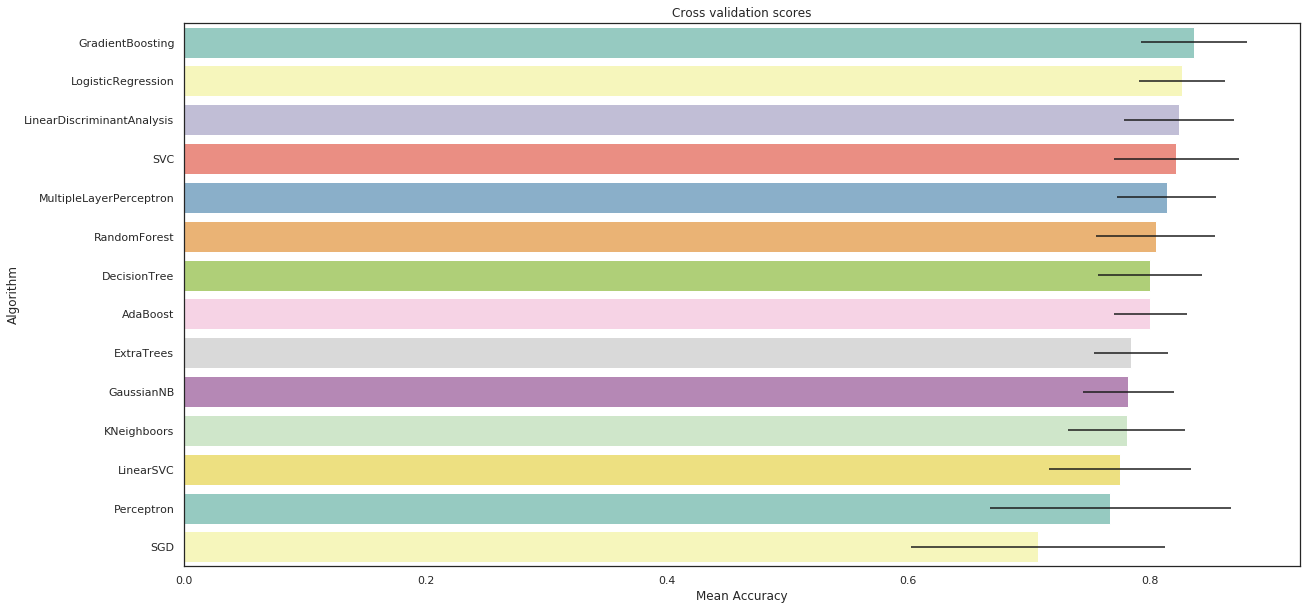

In [463]:
plt.figure(figsize=(20,10))
g = sns.barplot("CrossValMeans","Algorithm",data=cv_res.sort_values(by='CrossValMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## Hyperparameter Tuning

Grid search to find a optimal hyperparameter

In [464]:
# Plotting the results against an input with its training time
def plot_results(model, param='n_estimators', name='Num Trees'):
    param_name = 'param_%s' % param
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    plt.subplots(1, 2, figsize=(10,6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label='train')
    plt.plot(param_values, test_scores, 'go-', label='test')
    plt.ylim(ymin=0.6, ymax=1.0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel("Negative Mean Absolute Error")
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    #plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    plt.tight_layout(pad = 4)

### ADA Boost

In [465]:
# Adaboost Classifier
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)

In [466]:
# Random Hyperparamter Grid
n_estimators = [int(x) for x in np.linspace(start=1, stop=1000, num=10)]
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :n_estimators,
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

ada_random = RandomizedSearchCV(estimator=adaDTC, param_distributions=ada_param_grid, n_iter=100, cv=3, verbose=1, random_state=42, n_jobs=-1)
ada_random.fit(X_train,Y_train)
print(ada_random.best_score_)
ada_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


0.7979568671963677


{'n_estimators': 445,
 'learning_rate': 0.3,
 'base_estimator__splitter': 'random',
 'base_estimator__criterion': 'entropy',
 'algorithm': 'SAMME'}

In [467]:
# Grid Search with Cross Validation
ada_param_grid = {"base_estimator__criterion" : ["entropy", "gini"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME.R"],
              "n_estimators" : [1,2,5,10],
              "learning_rate":  [0.01,0.1,0.2,0.5,1.0,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, return_train_score=True)
gsadaDTC.fit(X_train,Y_train)

# Best score
print(gsadaDTC.best_score_)
# print(gsadaDTC.cv_results_.keys())
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s


0.8070374574347332


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    6.0s finished


{'algorithm': 'SAMME.R',
 'base_estimator__criterion': 'entropy',
 'base_estimator__splitter': 'best',
 'learning_rate': 0.2,
 'n_estimators': 2}

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


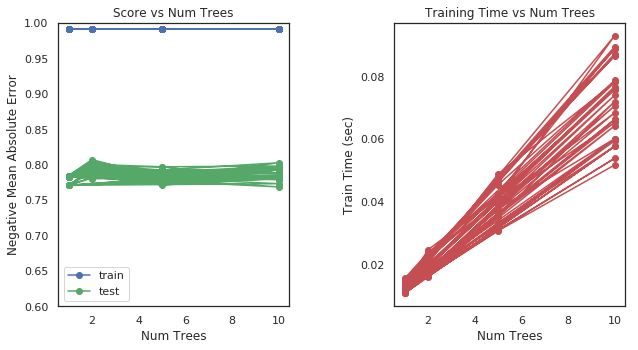

In [468]:
plot_results(gsadaDTC)

In [469]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, return_train_score=True)
gsExtC.fit(X_train,Y_train)

# Best score
print(gsExtC.best_score_)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   45.1s finished


0.8286038592508513


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


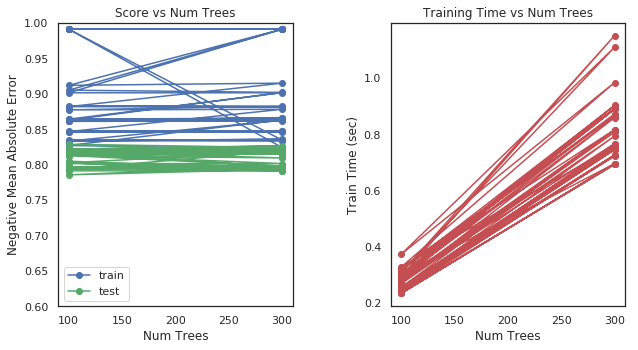

In [470]:
plot_results(gsExtC)

In [471]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100, 300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose=1, return_train_score=True)
gsRFC.fit(X_train,Y_train)

# Best score
print(gsRFC.best_score_)
#print(gsRFC.cv_results_.keys())
RFC_best = gsRFC.best_estimator_
gsRFC.best_params_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.7min finished


0.8331441543700341


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 300}

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


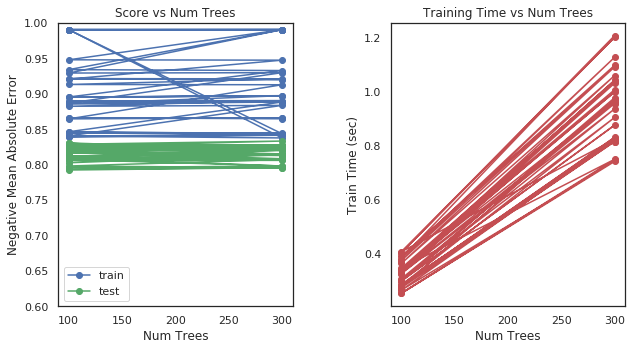

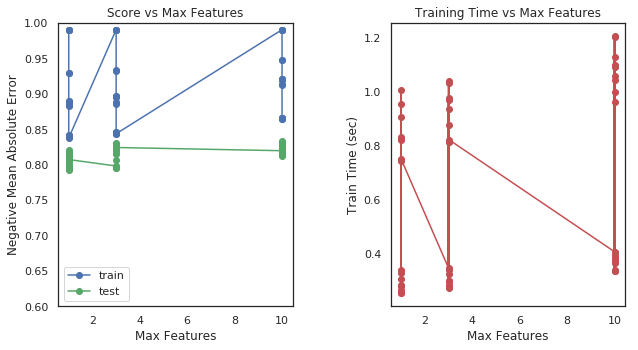

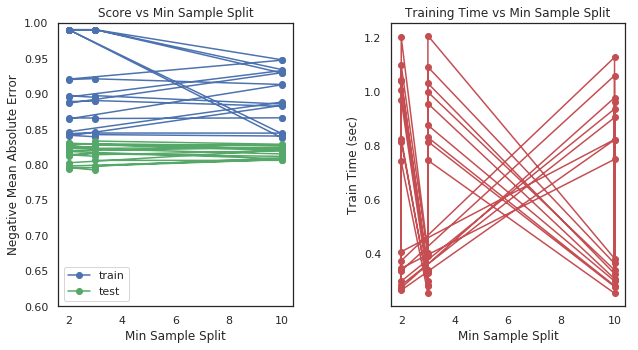

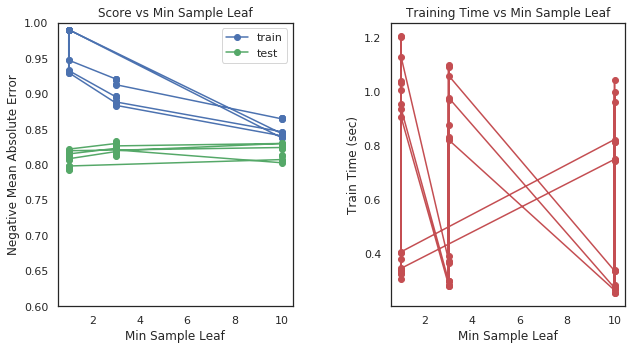

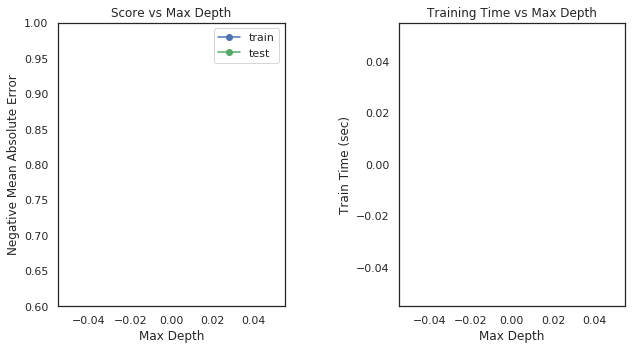

In [472]:
plot_results(gsRFC)
plot_results(gsRFC, param='max_features', name='Max Features')
plot_results(gsRFC, param='min_samples_split', name='Min Sample Split')
plot_results(gsRFC, param='min_samples_leaf', name='Min Sample Leaf')
plot_results(gsRFC, param='max_depth', name='Max Depth')

In [473]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100, 200, 300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100, 150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=10, scoring="accuracy", n_jobs=-1, verbose=1, return_train_score=True)
gsGBC.fit(X_train,Y_train)

# Best score
print(gsGBC.best_score_)
GBC_best = gsGBC.best_estimator_
gsGBC.best_params_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   44.2s finished


0.8297389330306469


{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 0.3,
 'min_samples_leaf': 100,
 'n_estimators': 300}

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


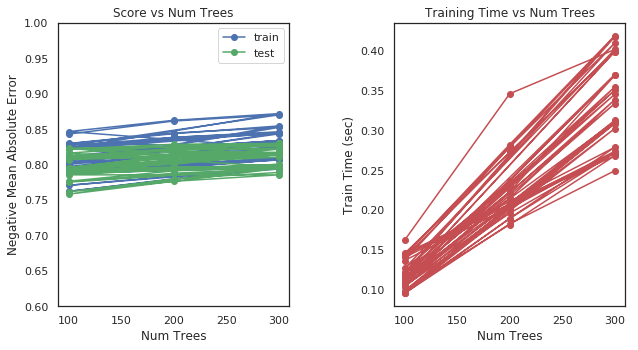

In [474]:
plot_results(gsGBC)

In [475]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.005, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1, return_train_score=True)
gsSVMC.fit(X_train,Y_train)

# Best score
print(gsSVMC.best_score_)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_params_

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   46.6s finished


0.8331441543700341


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


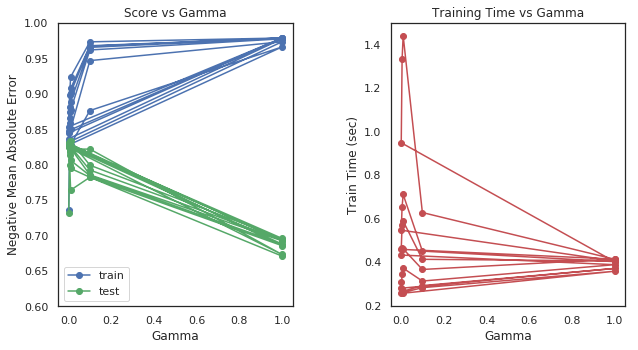

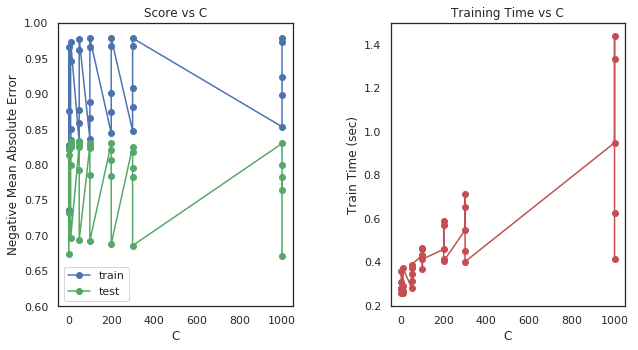

In [476]:
plot_results(gsSVMC, 'gamma', "Gamma")
plot_results(gsSVMC, 'C', "C")

### Learning Curve

Check if the models underfit / overfit

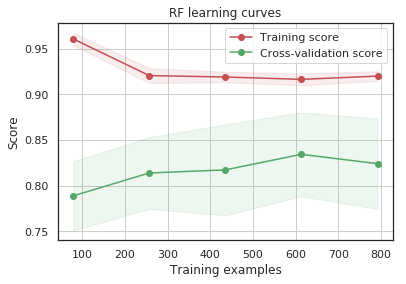

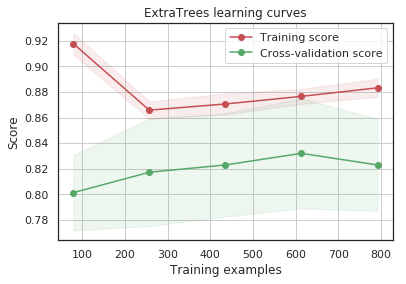

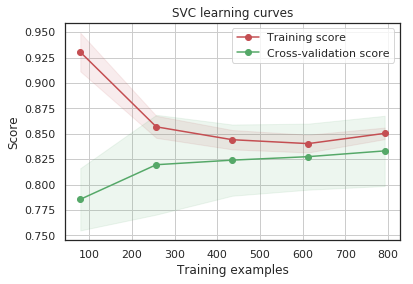

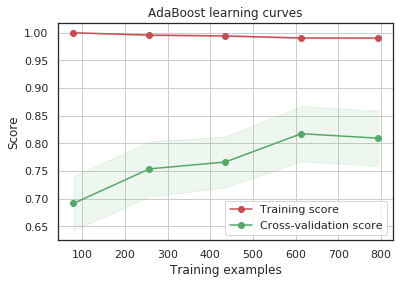

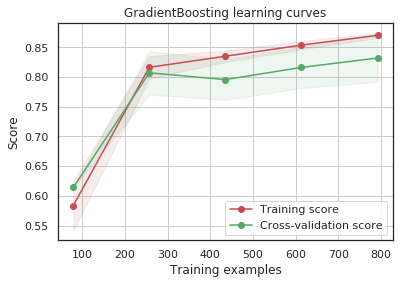

In [477]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

### Feature Importance

On four tree-based classifiers out of ten.

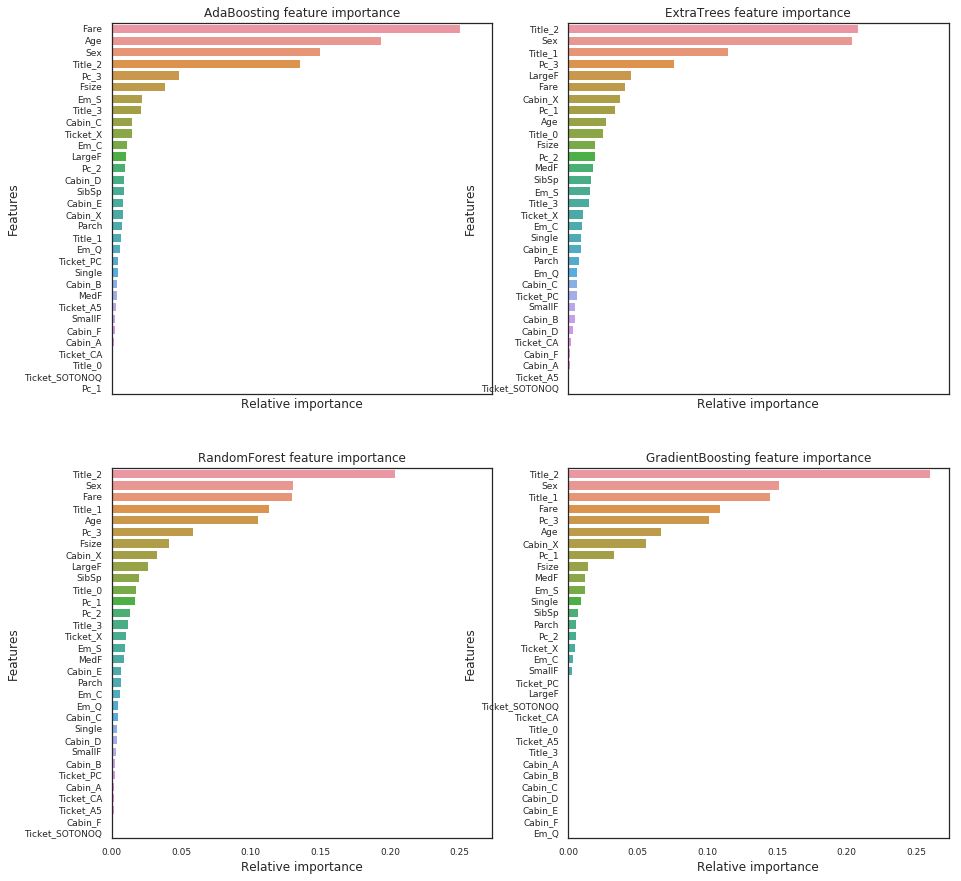

In [478]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

*Observations*

* Age, Sex, Family Size, Social Standing are more important than the location in the boat

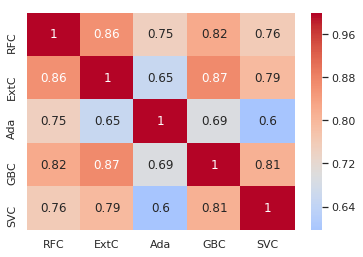

In [479]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

*Observations:*

* Predictions between RFC, ExtC, GBC and SVC are similar
* Predictions of Ada boost is different from the other four

In [ ]:
# Save Individual Results
test_Survived_AdaC.rename("Survived", inplace=True)
results_ADA = pd.concat([test_pid, test_Survived_AdaC], axis=1)
results_ADA.to_csv("ada_boost.csv", index=False)

test_Survived_ExtC.rename("Survived", inplace=True)
results_ExtC = pd.concat([test_pid, test_Survived_ExtC], axis=1)
results_ExtC.to_csv("extra_tree.csv", index=False)

test_Survived_RFC.rename("Survived", inplace=True)
results_RFC = pd.concat([test_pid, test_Survived_RFC], axis=1)
results_RFC.to_csv("random_forest.csv", index=False)

test_Survived_GBC.rename("Survived", inplace=True)
results_GBC = pd.concat([test_pid, test_Survived_GBC], axis=1)
results_GBC.to_csv("gradient_boost.csv", index=False)

test_Survived_SVMC.rename("Survived", inplace=True)
results_SVM = pd.concat([test_pid, test_Survived_SVMC], axis=1)
results_SVM.to_csv("support_vector_machine.csv", index=False)



### The other classifiers

In [487]:
test_survived = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_survived.append(pd.Series(estimator.predict(test), name=classifier[0]))

base_results = pd.concat(test_survived, axis=1)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


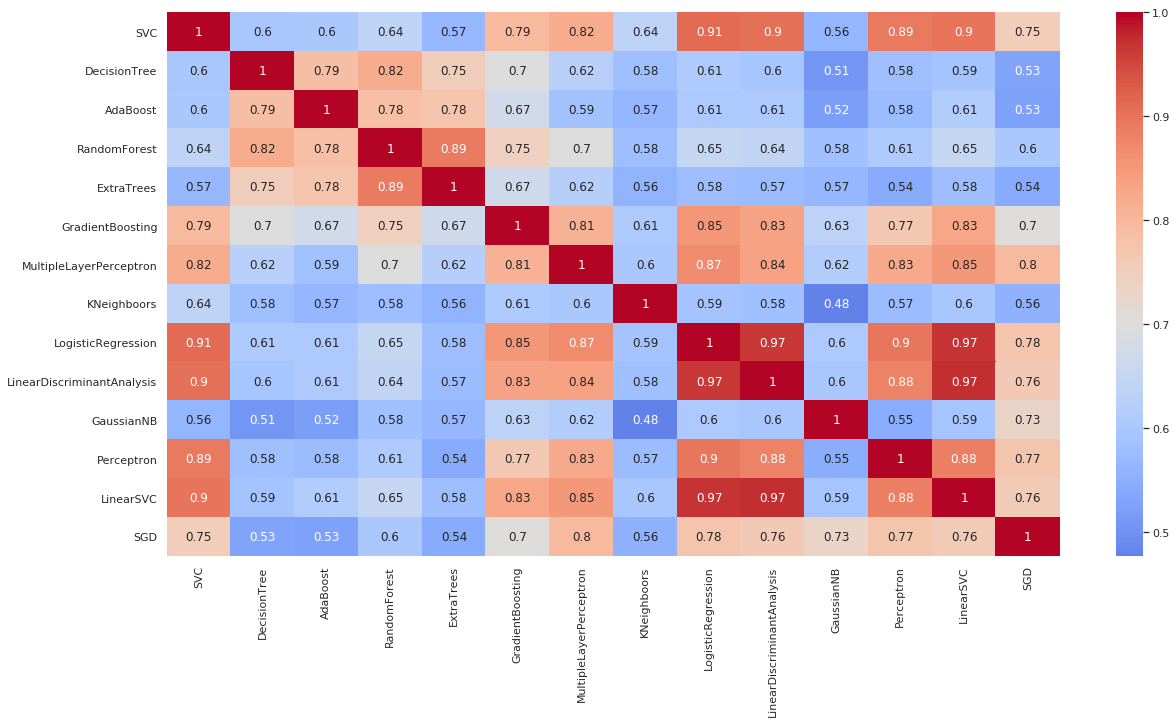

In [489]:
plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

## Ensembling

### Voting

In [490]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)
voting_best = voting_best.fit(X_train, Y_train)

In [561]:
# Predict
predict_voting = pd.Series(voting_best.predict(test), name="Survived")

# Save result
results = pd.concat([test_pid,predict_voting],axis=1)
results.to_csv("ensemble_best_voting.csv",index=False)

In [562]:
# Voting Classifier with "soft" to take all the probability into account
voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)
voting_base = voting_best.fit(X_train, Y_train)

In [563]:
# Predict
predict_voting = pd.Series(voting_base.predict(test), name="Survived")

# Save result
results = pd.concat([test_pid,predict_voting],axis=1)
results.to_csv("ensemble_base_voting.csv",index=False)

### XGBoost

In [ ]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    n_estimator=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(X_train, Y_train)
predict_xgb = pd.Series(gbm.predict(test), name="Survived")

# Save result
results = pd.concat([test_pid,predict_voting],axis=1)
results.to_csv("ensemble_xgb.csv",index=False)
